# Importando Bibliotecas

In [1]:
# ========================================================
# 1 - 📂 MANIPULAÇÃO DE ARQUIVOS E DIRETÓRIOS
# - Navegação, criação, movimentação e exclusão de arquivos/pastas
# ========================================================
import os                                                                   # Navegação entre diretórios, criação de caminhos
import io                                                                   # Manipulação de fluxos de entrada e saída
import pickle                                                               # Serialização e desserialização de objetos

# ========================================================
# 2 - 🔢 UTILITÁRIOS NUMÉRICOS E OPERAÇÕES MATEMÁTICAS
# - Manipulação de arrays, geração de aleatórios e operações auxiliares
# ========================================================
import numpy as np                                                          # Manipulação numérica com arrays e matrizes
import random                                                               # Geração de números aleatórios, embaralhamento
from tqdm import tqdm                                                       # Barra de progresso para loops e tarefas demoradas

# ========================================================
# 3 - 🖼️ LEITURA E PRÉ-PROCESSAMENTO DE IMAGENS
# - Leitura de imagens do disco, redimensionamento e validação de arquivos
# ========================================================
import cv2                                                                  # Processamento de imagem e vídeo
from PIL import Image                                                       # Leitura e conversão de imagens (usado por Dlib)

# ========================================================
# 4 - 👁️ DETECÇÃO E RECONHECIMENTO FACIAL (DLIB)
# - Localização de rostos e extração de embeddings faciais
# ========================================================
import dlib                                                                 # Biblioteca Dlib para detecção e reconhecimento facial

# ========================================================
# 5 - 🏋️ [ML][DL] PRÉ-PROCESSAMENTO PARA TREINAMENTO
# - Preparação dos dados de entrada e codificação de rótulos
# ========================================================
from sklearn.model_selection import train_test_split                        # Divisão de dados entre treino e teste

# ========================================================
# 6 - 🎨 [DL] SEGMENTAÇÃO SEMÂNTICA (TENSORFLOW / KERAS)
# - Segmentação de regiões da face em imagens detectadas
# ========================================================
import tensorflow as tf                                                     # Framework para Deep Learning
os.environ["SM_FRAMEWORK"] = "tf.keras"                                     # Define backend para segmentation_models
import segmentation_models as sm                                            # Modelos para segmentação semântica
import time                                                                 # Biblioteca para medir tempo de execução e criar timestamps
from datetime import datetime                                               # Geração de data/hora para nomeação de arquivos

# ========================================================
# 7 - 📊 [ML][DL] AVALIAÇÃO E VISUALIZAÇÃO DE RESULTADOS
# - Análise do desempenho do modelo e geração de gráficos
# ========================================================
from sklearn.metrics import classification_report, confusion_matrix         # Métricas de classificação
import matplotlib.pyplot as plt                                             # Visualização gráfica
import seaborn as sns                                                       # Gráficos estatísticos e heatmaps

# ========================================================
# 8 - 🎥 INTERFACE E ENTRADA DE DADOS (WEBCAM / UPLOAD)
# - Entrada ao vivo via webcam ou upload manual de imagem no notebook
# ========================================================
import ipywidgets as widgets                                                # Upload e interatividade via widgets no Jupyter
from IPython.display import display, clear_output                           # Exibição de imagens inline


Segmentation Models: using `tf.keras` framework.


# ETAPA 1 - Carregamento e Amostra de Imagens do Dataset

Nessa etapa, vamos:

1. Definir o caminho principal onde as imagens dos atores estão armazenadas.
2. Verificar se o diretório do dataset existe.
3. Listar os nomes dos atores (pastas) presentes no diretório.
4. Contar e exibir a quantidade de imagens disponíveis para cada ator.
5. Filtrar os arquivos válidos com extensões de imagem (.jpg, .jpeg, .png).
6. Exibir amostras visuais de imagens por ator para validar a qualidade e diversidade do dataset.

> ✅ Este passo é essencial para garantir que os dados estão organizados corretamente antes da geração dos embeddings faciais.

In [2]:
# Dataset
dataset_path = r"G:\Meu Drive\Computer Vision - Image Segmentation\dataset"

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Caminho não encontrado: {dataset_path}")
else:
    print("✅ Dataset carregado com sucesso!")

✅ Dataset carregado com sucesso!


In [3]:
# Lista todos os diretórios dentro do dataset (cada um representando um ator)
actors = sorted([
    actor for actor in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, actor))
])

# Imprime o nome de cada ator e o número de imagens disponíveis em cada pasta (apenas .jpg, .jpeg, .png)
for actor in actors:
    actor_folder = os.path.join(dataset_path, actor)

    num_images = len([
        f for f in os.listdir(actor_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    print(f"Ator: {actor} - Total de imagens: {num_images}")

Ator: Bruce_Banner (Mark Ruffalo) - Total de imagens: 100
Ator: Clint_Barton (Jeremy Renner) - Total de imagens: 100
Ator: Natasha_Romanoff (Scarlett Johansson) - Total de imagens: 100
Ator: Steve_Rogers (Chris Evans) - Total de imagens: 100
Ator: Thor (Chris Hemsworth) - Total de imagens: 100
Ator: Tony_Stark (Robert Downey Jr.) - Total de imagens: 100


### Visualizar amostras de imagens de cada ator

In [4]:
def show_samples(dataset_path, samples):
    """
    Exibe amostras de imagens organizadas por ator (sem data augmentation).

    Parâmetros:
        dataset_path (str): Caminho para o diretório do dataset.
        samples (int): Número de imagens por ator a serem exibidas.
    """
    actors = sorted(os.listdir(dataset_path))      # Lista ordenada de nomes dos atores (pastas)
    num_actors = len(actors)                       # Quantidade de atores (linhas da visualização)

    # Define o tamanho total da figura com base no número de amostras e atores
    plt.figure(figsize=(samples * 3, num_actors * 2.5))

    for row, actor in enumerate(actors):
        actor_path = os.path.join(dataset_path, actor)

        # Seleciona imagens aleatórias, limitando ao número máximo disponível
        img_names = random.sample(os.listdir(actor_path), min(samples, len(os.listdir(actor_path))))

        for col, img_name in enumerate(img_names):
            img_path = os.path.join(actor_path, img_name)
            img = cv2.imread(img_path)
            
            # Pula imagens que não puderam ser carregadas
            if img is None:
                continue

            # Converte BGR para RGB para exibição correta com matplotlib (visualização)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Define a posição do subplot (linha = ator, coluna = imagem)
            plt_idx = row * samples + col + 1
            plt.subplot(num_actors, samples, plt_idx)
            plt.imshow(img)
            plt.title(f"{img_name}\n[Original]", fontsize=10)
            plt.axis('off')

    # Ajusta o espaçamento para melhor visualização
    plt.tight_layout()
    plt.show()

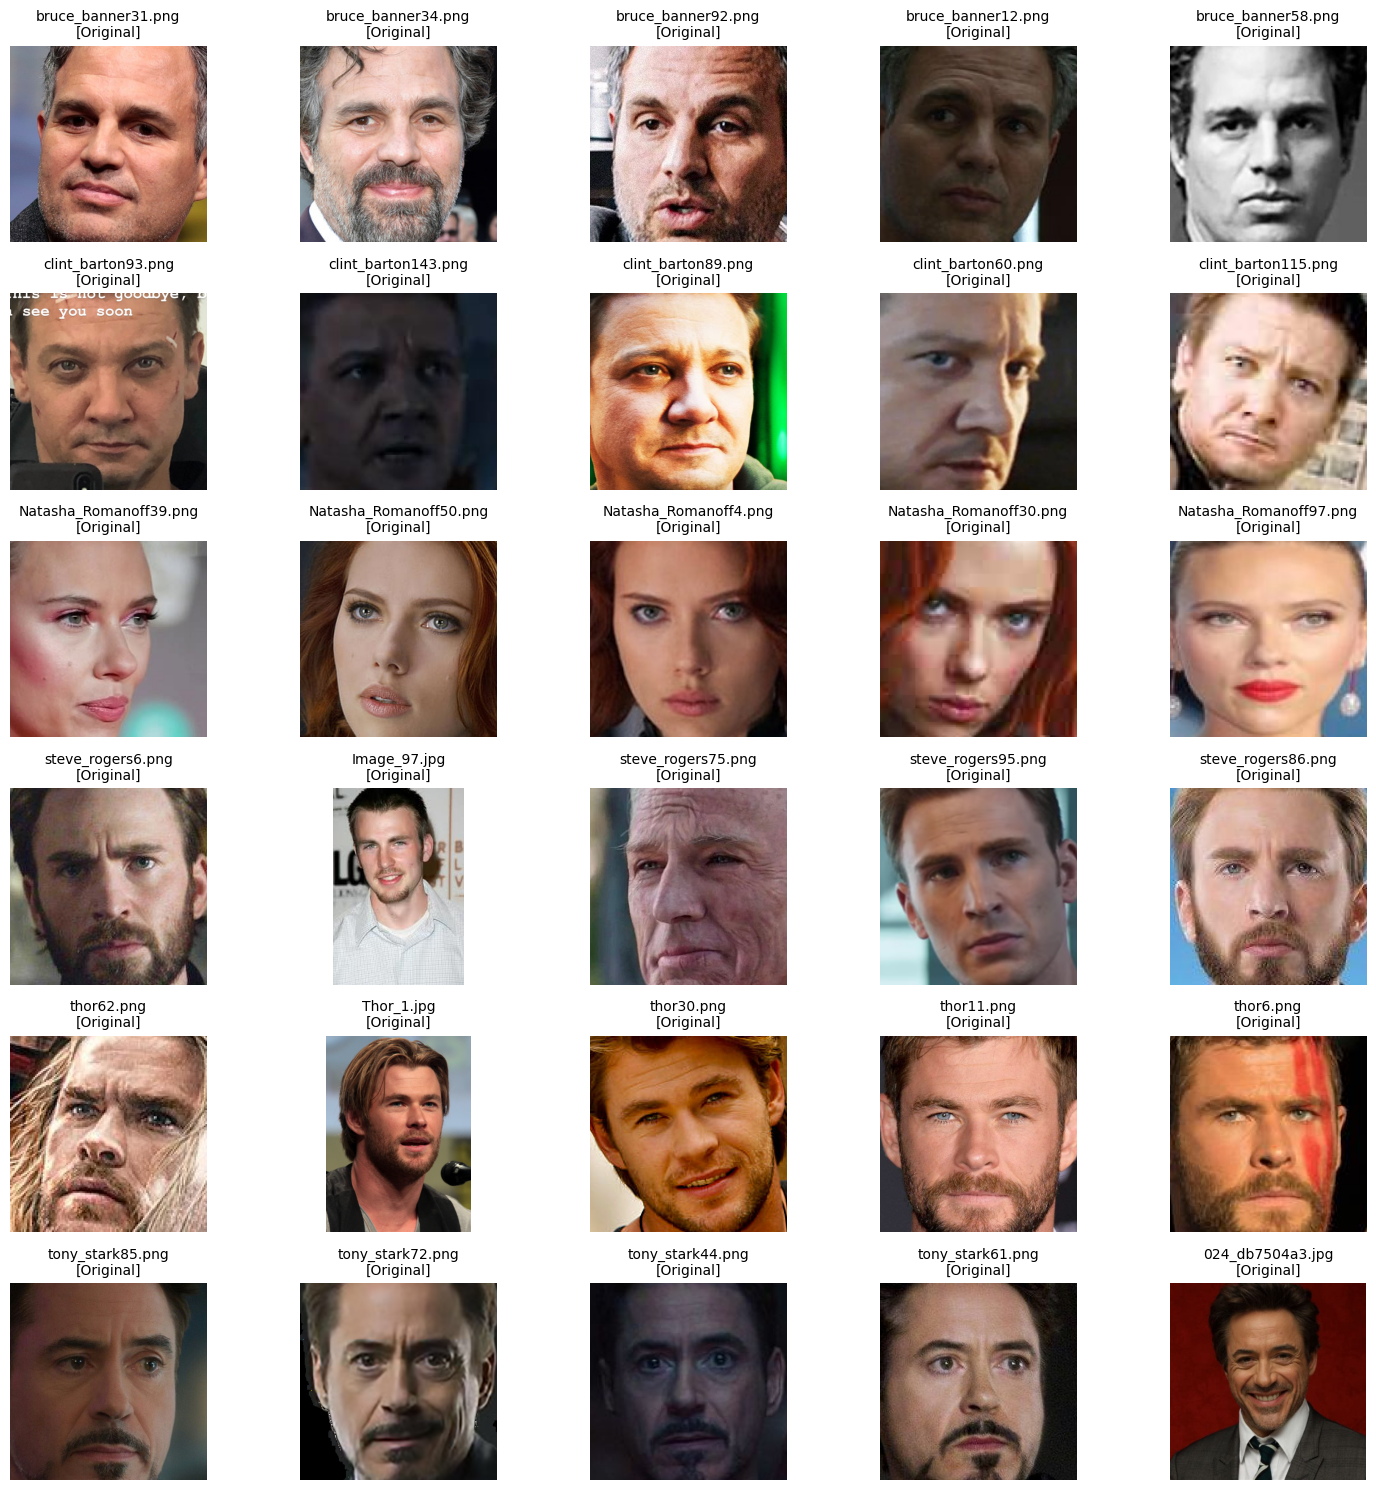

In [5]:
show_samples(dataset_path, samples=5)

# ETAPA 2 - Geração de Embeddings Faciais usando CNN ResNet34 (Dlib)

Nessa etapa, vamos:

1. Inicializar os modelos pré-treinados do Dlib:
   - Detector de faces frontal (`get_frontal_face_detector`).
   - Shape predictor (68 pontos faciais).
   - Modelo de reconhecimento facial baseado em ResNet (arquitetura de CNN).
2. Percorrer todas as imagens do dataset de atores.
3. Detectar faces e gerar embeddings para a **primeira face detectada** em cada imagem.
4. Armazenar os vetores gerados com os respectivos nomes dos atores em uma lista de dicionários.
5. Salvar o banco de embeddings em um arquivo `.pkl` para uso posterior nas etapas de predição.

> ✅ Essa etapa é fundamental para construir a base vetorial usada na comparação de similaridade facial nas etapas de reconhecimento. Cada embedding é um vetor de 128 dimensões que representa os traços únicos da face detectada.

In [6]:
# Inicializa o detector de face, shape predictor e modelo pré-treinado de reconhecimento facial do Dlib
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(r"G:\Meu Drive\Computer Vision - Image Segmentation\pre-trained models\shape_predictor_68_face_landmarks.dat")
face_rec_model = dlib.face_recognition_model_v1(r"G:\Meu Drive\Computer Vision - Image Segmentation\pre-trained models\dlib_face_recognition_resnet_model_v1.dat")

In [7]:
# Lista para armazenar todos os embeddings gerados e suas respectivas labels (nomes dos atores)
embeddings_db = []

# Percorre cada pasta (ator) presente no diretório do dataset
for actor in os.listdir(dataset_path):
    actor_dir = os.path.join(dataset_path, actor)

    # Ignora se não for um diretório
    if not os.path.isdir(actor_dir):
        continue
    
    # Itera sobre todas as imagens dentro da pasta do ator
    for img_name in tqdm(os.listdir(actor_dir), desc=f"Gerando embeddings de {actor}"):
        img_path = os.path.join(actor_dir, img_name)
        img = cv2.imread(img_path)
        
        # Ignora se a imagem não puder ser carregada
        if img is None:
            continue

        # Converte BGR para RGB (Dlib usa RGB)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detecta todas as faces presentes na imagem (com upsampling = 1 para melhorar a precisão)
        faces = face_detector(rgb, 1)

        # Gera embedding para a primeira face detectada
        for face in faces:
            # Detecta os 68 pontos faciais (landmarks)
            shape = shape_predictor(rgb, face)

            # Gera o vetor de características (embedding) da face
            face_descriptor = face_rec_model.compute_face_descriptor(rgb, shape)

            # Converte o descriptor para um array NumPy
            embedding = np.array(face_descriptor)

            # Armazena o embedding junto com o nome do ator
            embeddings_db.append({
                "label": actor,
                "embedding": embedding
            })

            # Só processa a primeira face encontrada em cada imagem
            break

Gerando embeddings de Natasha_Romanoff (Scarlett Johansson): 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]
Gerando embeddings de Bruce_Banner (Mark Ruffalo): 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]
Gerando embeddings de Clint_Barton (Jeremy Renner): 100%|██████████| 100/100 [00:06<00:00, 14.39it/s]
Gerando embeddings de Thor (Chris Hemsworth): 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]
Gerando embeddings de Tony_Stark (Robert Downey Jr.): 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


In [8]:
# Salva o banco de embeddings
with open(r"G:\Meu Drive\Computer Vision - Image Segmentation\models\face_embeddings_database.pkl", 'wb') as f:
    pickle.dump(embeddings_db, f)

print(f"Total de rostos processados: {len(embeddings_db)}")
print("\n✅ Banco de embeddings salvo com sucesso!")

Total de rostos processados: 561

✅ Banco de embeddings salvo com sucesso!


# ETAPA 3 - Avaliação do Modelo de Reconhecimento Facial com Embeddings (Dlib)

Nessa etapa, vamos:

1. Carregar o banco de embeddings salvo anteriormente no formato `.pkl`.
2. Separar os embeddings (`X`) e seus respectivos rótulos (`y`) para formar os conjuntos de treino e teste.
3. Dividir os dados com `train_test_split`, utilizando o parâmetro `stratify` para manter a proporção entre as classes.
4. Realizar a predição no conjunto de teste com base em **vizinhança por distância Euclidiana**:
   - Para cada embedding de teste, calcular a distância até todos os embeddings de treino.
   - Selecionar o rótulo do embedding de treino mais próximo como a predição final.
5. Avaliar a performance do modelo com:
   - **Relatório de classificação** (`classification_report`): precisão, recall e f1-score por classe.
   - **Matriz de confusão**: visualiza acertos e erros entre as classes.
6. Exibir a matriz de confusão como um **mapa de calor (heatmap)** com Seaborn para facilitar a análise visual.

> ✅ Essa abordagem baseada em vizinho mais próximo (nearest neighbor) é simples e eficaz para avaliar o poder discriminativo dos embeddings gerados com Dlib.

In [9]:
# Carrega banco de embeddings
with open(r"G:\Meu Drive\Computer Vision - Image Segmentation\models\face_embeddings_database.pkl", "rb") as f:
    embeddings_db = pickle.load(f)

# Separa os embeddings (X) e os respectivos rótulos (y)
X = [entry["embedding"] for entry in embeddings_db]
y = [entry["label"] for entry in embeddings_db]

# Separa em treino e teste (o parâmetro stratify garante que a proporção de classes seja mantida nos dois conjuntos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Lista para armazenar os rótulos preditos para o conjunto de teste
y_pred = []

for test_embedding in X_test:
    # Calcula a distância euclidiana até todos os embeddings do conjunto de treino
    distances = [np.linalg.norm(test_embedding - train_embedding) for train_embedding in X_train]

    # Encontra o índice do vetor mais próximo (menor distância)
    min_idx = np.argmin(distances)

    # Associa o rótulo correspondente ao embedding mais próximo como predição
    predicted_label = y_train[min_idx]

    # Adiciona o rótulo predito à lista
    y_pred.append(predicted_label)

# Avaliação
print("📊 Relatório de Classificação:")
print(classification_report(y_test, y_pred))

📊 Relatório de Classificação:
                                       precision    recall  f1-score   support

          Bruce_Banner (Mark Ruffalo)       1.00      1.00      1.00        20
         Clint_Barton (Jeremy Renner)       1.00      1.00      1.00        19
Natasha_Romanoff (Scarlett Johansson)       1.00      1.00      1.00        19
           Steve_Rogers (Chris Evans)       1.00      1.00      1.00        18
               Thor (Chris Hemsworth)       1.00      1.00      1.00        18
       Tony_Stark (Robert Downey Jr.)       1.00      1.00      1.00        19

                             accuracy                           1.00       113
                            macro avg       1.00      1.00      1.00       113
                         weighted avg       1.00      1.00      1.00       113



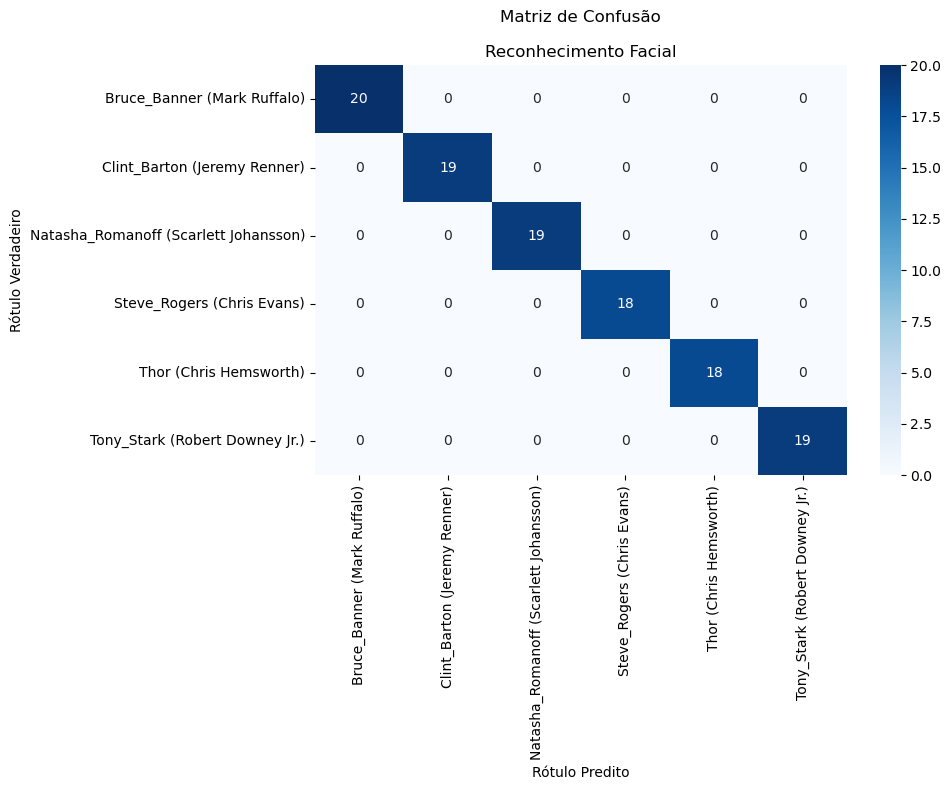

In [10]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel("Rótulo Predito")
plt.ylabel("Rótulo Verdadeiro")
plt.title("Matriz de Confusão\n\nReconhecimento Facial")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ETAPA 4 – Reconhecimento Facial em Tempo Real e por Imagens Estáticas (Reconhecimento de Atores)

Nesta etapa, o sistema de reconhecimento facial é avaliado em dois cenários distintos:

- **ETAPA 4.1 – Reconhecimento Facial em Tempo Real via Webcam**  
  Captura frames periodicamente da webcam para realizar a detecção de rostos, o reconhecimento facial com base em embeddings (Dlib) e a segmentação semântica das regiões faciais reconhecidas.

- **ETAPA 4.2 – Reconhecimento Facial por Upload de Imagens**  
  Permite o envio de arquivos de imagem estáticos (.jpg, .jpeg, .png) diretamente no notebook. O processo inclui detecção, reconhecimento facial e segmentação das faces presentes.

> ✅ Ambas as abordagens utilizam a **mesma base de embeddings faciais** e o modelo **U-Net com backbone ResNet34** para segmentação, garantindo consistência nos dois modos de operação.

### ETAPA 4.1 - Reconhecimento Facial via Webcam com Embeddings (Dlib) e Segmentação Semântica com U-Net + ResNet34

Nesta etapa, realizamos o reconhecimento facial em tempo real utilizando a webcam, combinando o poder dos **embeddings faciais do Dlib** com a **segmentação semântica baseada na arquitetura U-Net com backbone ResNet34**.

O que será feito:

1. **Carregamento dos modelos do Dlib**, incluindo:
   - Detector de faces frontal (`get_frontal_face_detector`)
   - Shape predictor (68 pontos faciais)
   - Modelo de reconhecimento facial baseado em ResNet (arquitetura de CNN).
2. **Leitura do banco de embeddings** previamente salvo (na Etapa 2).
3. **Carregamento do modelo de segmentação semântica U-Net**, treinado para segmentar rostos em imagens.
4. **Inicialização da webcam** com resolução definida para capturar imagens em tempo real.
5. **Processamento contínuo dos frames capturados**:
   - Detectar todas as faces no frame usando Dlib.
   - Calcular o vetor de embedding para cada face detectada.
   - Comparar com os embeddings conhecidos e identificar o ator (ou marcar como "Desconhecido").
   - Exibir o nome da pessoa reconhecida e um retângulo colorido (verde para reconhecido, vermelho para desconhecido).
   - A cada intervalo de tempo (ex: a cada 5 segundos), aplicar a segmentação na região da face.
   - Se a pessoa for reconhecida:
     - **Corrigir iluminação e contraste da imagem segmentada**, preservando fidelidade visual em relação ao frame original.
     - **Ampliar a região segmentada para incluir a testa**, ajustando a linha da sobrancelha para cima ao gerar o contorno facial anatômico.
     - **Salvar a imagem segmentada da face com transparência (canal alfa)** e com o nome + timestamp.
6. **Exibição contínua dos frames processados** diretamente no Jupyter Notebook com `IPython.display`.
7. **Interrupção manual segura** com `KeyboardInterrupt` (Ctrl+C ou botão de interrupção da célula).

> ✅ Essa etapa permite validar a eficácia do sistema de reconhecimento em um ambiente real e dinâmico, aplicando segmentação avançada para isolar apenas a região relevante da face com alta precisão e aparência natural.

In [14]:
# Inicializa o detector de face, shape predictor e modelo pré-treinado de reconhecimento facial do Dlib
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(r"G:\Meu Drive\Computer Vision - Image Segmentation\pre-trained models\shape_predictor_68_face_landmarks.dat")
face_rec_model = dlib.face_recognition_model_v1(r"G:\Meu Drive\Computer Vision - Image Segmentation\pre-trained models\dlib_face_recognition_resnet_model_v1.dat")

In [15]:
# Carrega o banco de embeddings (lista de dicionários com 'label' e 'embedding')
with open(r"G:\Meu Drive\Computer Vision - Image Segmentation\models\face_embeddings_database.pkl", 'rb') as f:
    embeddings_db = pickle.load(f)

# Valida se o banco de embeddings está carregado corretamente
if not embeddings_db:
    print("❌ Banco de embeddings está vazio ou não pôde ser carregado.")
    raise SystemExit

# Carrega o modelo de segmentação semântica
seg_model = sm.Unet('resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')

# Define o diretório para salvar as imagens segmentadas
save_dir_webcam = r"G:\Meu Drive\Computer Vision - Image Segmentation\face recognition\webcam"
os.makedirs(save_dir_webcam, exist_ok=True)

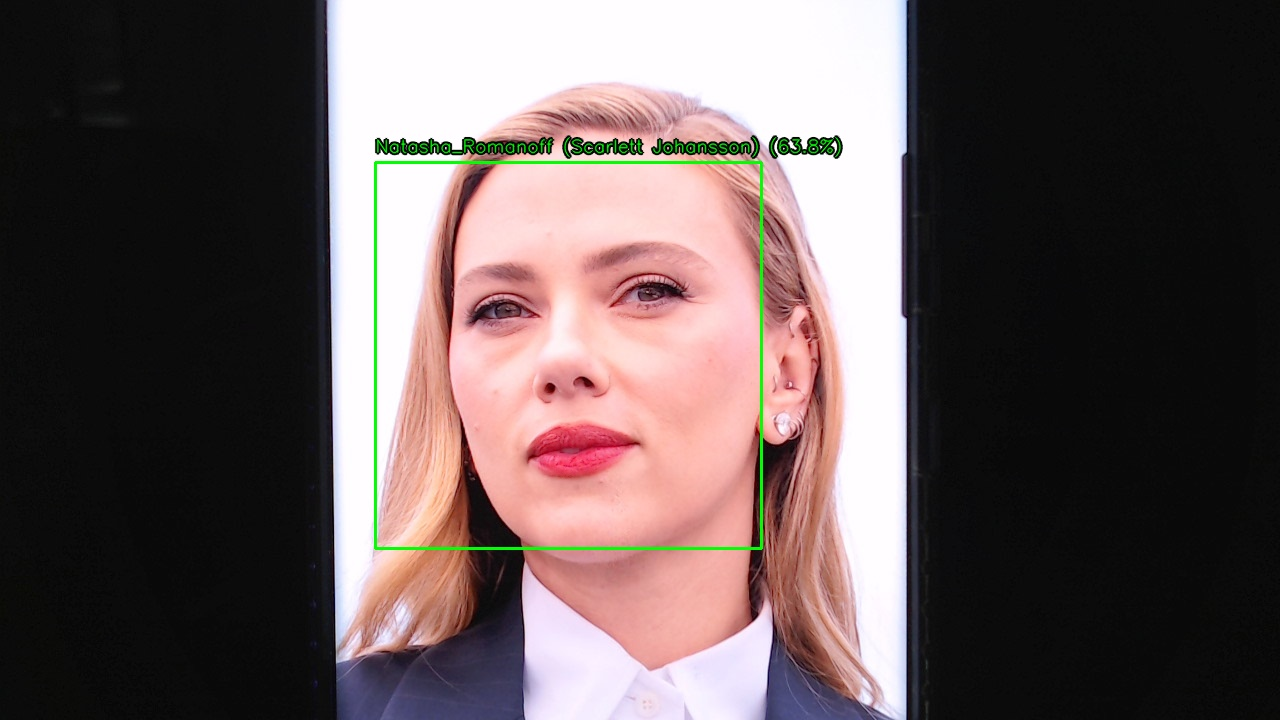

🟢 Reconhecimento iniciado — pare a célula para interromper.
🛑 Reconhecimento interrompido manualmente.


In [ ]:
# Inicializa a webcam e define a resolução
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Define o intervalo entre frames processados (em segundos)
frame_interval = 5.0        # processa 1 frame a cada 5 segundos
last_processed_time = 0     # marca o tempo do último processamento

try:
    while True:
        print("🟢 Reconhecimento iniciado — pare a célula para interromper.")
        ret, frame = cap.read()
        if not ret:
            break

        # Converte frame para RGB para processamento com Dlib
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detecta faces no frame atual
        detections = face_detector(rgb_frame, 1)   # com upsampling

        # Captura tempo atual
        current_time = time.time()

        for face in detections:
            # Extrai pontos de referência faciais
            shape = shape_predictor(rgb_frame, face)

            # Gera vetor de embedding da face
            face_descriptor = face_rec_model.compute_face_descriptor(rgb_frame, shape)
            face_embedding = np.array(face_descriptor)

            # Calcula distâncias euclidianas para cada embedding salvo no banco de embeddings
            distances = [np.linalg.norm(face_embedding - entry["embedding"]) for entry in embeddings_db]
            min_distance_idx = int(np.argmin(distances))
            min_distance = distances[min_distance_idx]

            # Verifica se o rosto foi reconhecido
            threshold = 0.5
            if min_distance < threshold:
                name = embeddings_db[min_distance_idx]["label"]
                confidence = (1 - min_distance) * 100
                label = f"{name} ({confidence:.1f}%)"
                color = (0, 255, 0)  # verde
            else:
                name = "Desconhecido"
                label = f"{name} ({(1 - min_distance) * 100:.1f}%)"
                color = (0, 0, 255)  # vermelho

            # Desenha bounding box e rótulo no frame
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1, cv2.LINE_AA)
            
            # Segmentação e salvamento de rosto apenas no intervalo definido
            if (current_time - last_processed_time) >= frame_interval:
                last_processed_time = current_time

                # Corrige coordenadas para dentro da imagem
                x1 = max(0, x)
                y1 = max(0, y)
                x2 = min(rgb_frame.shape[1], x + w)
                y2 = min(rgb_frame.shape[0], y + h)

                # Recorta a região da face para segmentação
                face_img = rgb_frame[y1:y2, x1:x2]

                # Protege contra faces muito próximas ou fora do quadro
                if face_img.size == 0 or face_img.shape[0] < 20 or face_img.shape[1] < 20:
                    print("⚠️ Face muito pequena ou inválida para segmentação.")
                    continue

                # Redimensiona e normaliza a face para o modelo de segmentação U-Net
                face_resized = cv2.resize(face_img, (224, 224)) / 255.0
                face_input = np.expand_dims(face_resized, axis=0)

                # Prediz máscara de segmentação
                mask = seg_model.predict(face_input)[0, :, :, 0]

                # Redimensiona a máscara para o tamanho original da face
                soft_mask = cv2.resize(mask, (face_img.shape[1], face_img.shape[0]))

                # CRIA MÁSCARA ANATÔMICA: Recalcula os landmarks relativos ao recorte da face
                landmarks = np.array([[shape.part(n).x - x1, shape.part(n).y - y1] for n in range(68)])

                # Cria uma máscara em branco com o mesmo tamanho da face recortada
                face_mask = np.zeros((face_img.shape[0], face_img.shape[1]), dtype=np.uint8)

                # Ajusta pontos da sobrancelha para cima para incluir a testa
                eyebrow_pts = landmarks[17:27].copy()
                eyebrow_pts[:, 1] -= int(face_img.shape[0] * 0.20)  # levanta 20% da altura da imagem

                # Cria contorno da face: mandíbula + contorno acima da sobrancelha invertido
                face_contour = np.concatenate([
                    landmarks[0:17],         # mandíbula (queixo até orelhas)
                    eyebrow_pts[::-1]        # sobrancelha elevada (testa)
                ])
                cv2.fillConvexPoly(face_mask, face_contour, 255)

                # Combina a máscara semântica com a anatômica
                combined_mask = cv2.bitwise_and((soft_mask * 255).astype(np.uint8), face_mask)

                # Converte para RGBA e insere a máscara como canal alfa
                segmented_face_rgba = cv2.cvtColor(face_img, cv2.COLOR_RGB2RGBA)
                segmented_face_rgba[:, :, 3] = combined_mask

                # Salva apenas se for reconhecido
                if name != "Desconhecido":
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                    filename = f"{name}_{timestamp}.png"
                    filepath = os.path.join(save_dir_webcam, filename)
                    cv2.imwrite(filepath, cv2.cvtColor(segmented_face_rgba, cv2.COLOR_RGBA2BGRA))

        # Exibe o frame atualizado no Jupyter
        _, encoded_frame = cv2.imencode('.jpg', frame)
        clear_output(wait=True)
        display(Image.open(io.BytesIO(encoded_frame.tobytes())))

except KeyboardInterrupt:
    print("🛑 Reconhecimento interrompido manualmente.")

# Libera a webcam e fecha as janelas após a execução
cap.release()
cv2.destroyAllWindows()

### ETAPA 4.2 - Reconhecimento Facial via Upload com Embeddings (Dlib) e Segmentação Semântica com U-Net + ResNet34

Nesta etapa, implementamos um sistema de reconhecimento facial através do **upload de imagens estáticas**. A solução combina **embeddings faciais gerados com o Dlib** com **segmentação semântica por U-Net com ResNet34**, permitindo identificar e extrair rostos conhecidos em imagens enviadas pelo usuário.

1. **Carregamento dos modelos Dlib**:
   - Detector de faces frontal (`get_frontal_face_detector`)
   - Shape predictor de 68 pontos faciais
   - Modelo de reconhecimento facial baseado em ResNet (arquitetura de CNN)
2. **Carregamento do banco de embeddings faciais**, previamente criado e armazenado como arquivo `.pkl`.
3. **Carregamento do modelo de segmentação U-Net** com backbone `resnet34`, configurado para gerar máscaras binárias das regiões faciais.
4. **Função principal `recognize_faces_in_uploaded_image`**:
   - Converte a imagem enviada para o formato apropriado (RGB).
   - Detecta as faces presentes usando o Dlib.
   - Para cada face:
     - Gera seu vetor de embedding.
     - Compara com o banco de embeddings.
     - Se a menor distância for inferior ao limiar (ex.: 0.5), considera a face reconhecida.
     - Realiza a segmentação da face detectada com o modelo U-Net.
     - Aplica uma **máscara combinada**, resultante da união da máscara semântica (U-Net) com uma máscara anatômica derivada dos landmarks (mandíbula + sobrancelha elevada, cobrindo também a testa).
     - Gera uma imagem **com canal alfa (RGBA)** que destaca apenas a região relevante da face com transparência ao redor.
     - Salva a imagem segmentada com o nome da pessoa e timestamp, caso a face seja reconhecida.
   - Exibe no notebook a imagem original anotada com bounding boxes e nomes reconhecidos.
5. **Interface interativa com Jupyter Notebook**:
   - Um botão de upload (`FileUpload`) permite ao usuário enviar imagens nos formatos `.jpg`, `.jpeg` ou `.png`.
   - Ao detectar o upload, a função de reconhecimento e segmentação é automaticamente executada para cada arquivo enviado.

> ✅ Essa abordagem permite processar múltiplas imagens com precisão e transparência, oferecendo um fluxo controlado e ideal para testes offline, análise de resultados e construção de pipelines automatizados baseados em imagens faciais reais.

In [11]:
# Inicializa o detector de face, shape predictor e modelo pré-treinado de reconhecimento facial do Dlib
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(r"G:\Meu Drive\Computer Vision - Image Segmentation\pre-trained models\shape_predictor_68_face_landmarks.dat")
face_rec_model = dlib.face_recognition_model_v1(r"G:\Meu Drive\Computer Vision - Image Segmentation\pre-trained models\dlib_face_recognition_resnet_model_v1.dat")

In [12]:
# Carrega banco de embeddings faciais
with open(r"G:\Meu Drive\Computer Vision - Image Segmentation\models\face_embeddings_database.pkl", "rb") as f:
    embeddings_db = pickle.load(f)

# Verifica se o banco está carregado corretamente
if not embeddings_db:
    print("❌ Banco de embeddings está vazio ou não pôde ser carregado.")
    raise SystemExit

# Diretório de salvamento das faces segmentadas
save_dir_upload = r"G:\Meu Drive\Computer Vision - Image Segmentation\face recognition\upload"
os.makedirs(save_dir_upload, exist_ok=True)

# Carrega modelo de segmentação semântica U-Net com backbone ResNet34
seg_model = sm.Unet('resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')

In [13]:
# Função para reconhecimento facial e segmentação em imagens carregadas
def recognize_faces_in_uploaded_image(img_bytes):
    # Converte os bytes da imagem em formato array NumPy (OpenCV BGR)
    nparr = np.frombuffer(img_bytes, np.uint8)
    img_bgr = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Detecta rostos com upsampling para aumentar precisão
    faces = face_detector(img_rgb, 1)

    if not faces:
        print("⚠️ Nenhuma face detectada na imagem enviada.")
        return

    for face in faces:
        # Extrai landmarks e gera embedding facial
        shape = shape_predictor(img_rgb, face)
        face_descriptor = face_rec_model.compute_face_descriptor(img_rgb, shape)
        face_embedding = np.array(face_descriptor)

        # Compara com o banco de embeddings
        distances = [np.linalg.norm(face_embedding - entry["embedding"]) for entry in embeddings_db]
        if not distances:
            continue
        min_distance_idx = int(np.argmin(distances))
        min_distance = distances[min_distance_idx]

        # Verifica se o rosto foi reconhecido
        threshold = 0.5
        if min_distance < threshold:
            name = embeddings_db[min_distance_idx]["label"]
            confidence = (1 - min_distance) * 100
            label = f"{name} ({confidence:.1f}%)"
            color = (0, 255, 0)     # Verde
        else:
            name = "Desconhecido"
            label = f"{name} ({(1 - min_distance) * 100:.1f}%)"
            color = (0, 0, 255)     # Vermelho

        # Desenha bounding box e rótulo na imagem
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cv2.rectangle(img_bgr, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img_bgr, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(img_bgr, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1, cv2.LINE_AA)

        # Corrige coordenadas para dentro da imagem
        x1 = max(0, x)
        y1 = max(0, y)
        x2 = min(img_rgb.shape[1], x + w)
        y2 = min(img_rgb.shape[0], y + h)

        # Recorta a região da face para segmentação
        face_img = img_rgb[y1:y2, x1:x2]

        # Protege contra faces muito próximas ou fora do quadro
        if face_img.size == 0 or face_img.shape[0] < 20 or face_img.shape[1] < 20:
            print("⚠️ Face muito pequena ou inválida para segmentação.")
            continue

        # Redimensiona e normaliza a face para o modelo de segmentação U-Net
        face_resized = cv2.resize(face_img, (224, 224)) / 255.0
        face_input = np.expand_dims(face_resized, axis=0)

        # Prediz máscara de segmentação
        mask = seg_model.predict(face_input)[0, :, :, 0]

        # Redimensiona a máscara para o tamanho original da face
        soft_mask = cv2.resize(mask, (face_img.shape[1], face_img.shape[0]))

        # CRIA MÁSCARA ANATÔMICA: Recalcula os landmarks relativos ao recorte da face
        landmarks = np.array([[shape.part(n).x - x1, shape.part(n).y - y1] for n in range(68)])

        # Cria uma máscara em branco com o mesmo tamanho da face recortada
        face_mask = np.zeros((face_img.shape[0], face_img.shape[1]), dtype=np.uint8)

        # Ajusta pontos da sobrancelha para cima para incluir a testa
        eyebrow_pts = landmarks[17:27].copy()
        eyebrow_pts[:, 1] -= int(face_img.shape[0] * 0.20)  # levanta 20% da altura da imagem

        # Cria contorno da face: mandíbula + contorno acima da sobrancelha invertido
        face_contour = np.concatenate([
            landmarks[0:17],         # mandíbula (queixo até orelhas)
            eyebrow_pts[::-1]        # sobrancelha elevada (testa)
        ])
        cv2.fillConvexPoly(face_mask, face_contour, 255)

        # Combina a máscara semântica com a anatômica
        combined_mask = cv2.bitwise_and((soft_mask * 255).astype(np.uint8), face_mask)

        # Converte para RGBA e insere a máscara como canal alfa
        segmented_face_rgba = cv2.cvtColor(face_img, cv2.COLOR_RGB2RGBA)
        segmented_face_rgba[:, :, 3] = combined_mask

        # Salva apenas se for reconhecido
        if name != "Desconhecido":
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{name}_{timestamp}.png"
            filepath = os.path.join(save_dir_upload, filename)
            cv2.imwrite(filepath, cv2.cvtColor(segmented_face_rgba, cv2.COLOR_RGBA2BGRA))

    # Exibe a imagem processada com anotações no Jupyter
    _, encoded_img = cv2.imencode('.jpg', img_bgr)
    display(Image.open(io.BytesIO(encoded_img.tobytes())))

In [ ]:
# Botão de upload de arquivos (.jpg, .jpeg, .png)
upload_btn = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=True)
output = widgets.Output()

# Callback executado após upload
def on_upload_change(change):
    output.clear_output()
    with output:
        if upload_btn.value:
            for file_info in upload_btn.value:
                print(f"✅ Arquivo carregado: {file_info.name}")
                recognize_faces_in_uploaded_image(file_info.content)

# Observa mudanças no botão de upload
upload_btn.observe(on_upload_change, names='value')

# Exibe interface no notebook
display(widgets.VBox([
    widgets.Label("📤 Envie uma ou mais imagens para reconhecimento facial com segmentação:"),
    upload_btn,
    output
]))